## Illustration of PPO agent applied to a farming environment from farm-gym

### Imports:

In [1]:
# classical libraries
import numpy as np
import pandas as pd
import seaborn as sns

# farm-gym pre-made environments
import farmgym_games

# RL library
from rlberry.agents.torch import PPOAgent
from rlberry.manager import AgentManager, evaluate_agents, plot_writer_data
from rlberry.agents.torch.utils.training import model_factory_from_env
from rlberry.envs import gym_make

### Settings :
We'll use the `Farm1` environment

In [2]:
env_ctor, env_kwargs = gym_make, {"id": "OldV21Farm1-v0"} # rlberry is gym v0.21 compatible. Use "id"="Farm1-v0" for gym v0.26 compatibility

We use an architecture of $256\times 256$ for both the value and policy neural network of ppo.

In [3]:

policy_configs = {
    "type": "MultiLayerPerceptron",  # A network architecture
    "layer_sizes": (256, 256),  # Network dimensions
    "reshape": False,
    "is_policy": True,
}

value_configs = {
    "type": "MultiLayerPerceptron",
    "layer_sizes": (256, 256),
    "reshape": False,
    "out_size": 1,
}

### Agent code:
We use rlberry's [PPOAgent](https://rlberry.readthedocs.io/en/latest/generated/rlberry.agents.torch.PPOAgent.html#rlberry.agents.torch.PPOAgent). 
Remark that 365 days is the maximum lenght of an episode. This helps us to fix some of the parameters.

In [4]:
manager = AgentManager(
        PPOAgent,
        (env_ctor, env_kwargs),
        agent_name="PPOAgent",
        init_kwargs=dict(
            policy_net_fn=model_factory_from_env,
            policy_net_kwargs=policy_configs,
            value_net_fn=model_factory_from_env,
            value_net_kwargs=value_configs,
            learning_rate=9e-5,
            n_steps=5 * 365,
            batch_size=365,
            eps_clip=0.2,
        ),
        fit_budget=5e5,
        eval_kwargs=dict(eval_horizon=365),
        n_fit=1,
        seed = 42, # Important: as farm-gym is very stochastic, for some choice of seed PPO does not train and the final reward is 0 !
        output_dir="ppo1_results", # results/trained agents are kept in this directory
    )
manager.fit()

[INFO] 16:46: Running AgentManager fit() for PPOAgent with n_fit = 1 and max_workers = None. 
/home/frost/.local/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/frost/.local/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/frost/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/frost/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment 

### Training reward curve

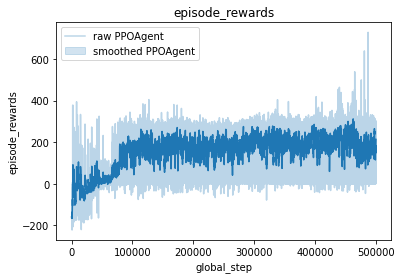

In [5]:
data = plot_writer_data(manager, tag="episode_rewards", smooth_weight=0.8) # smoothing tensorboard-style

### Evaluation of the trained agent

In [6]:
evaluation = evaluate_agents([manager], n_simulations=128, plot=False)
evaluation.describe()

[INFO] 17:00: Evaluating PPOAgent... 
[INFO] Evaluation:/home/frost/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/frost/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/frost/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(
/home/frost/.local/lib/python3.10/site-packages/gym/utils/passive_e

,PPOAgent
count,128.000000
mean,185.779274
std,36.115669
min,82.613569
25%,158.785278
50%,184.637599
75%,218.280214
max,258.224123


### Small peek into the agents policy

In [7]:
agent = manager.agent_handlers[0] # select the agent from the manager

In [9]:
env = env_ctor(**env_kwargs)
obs = env.reset()

actions_txt = ["doing nothing", 
           "1L of water", 
           "5L of water", 
           "harvesting",
           "sow some seeds",
           "scatter fertilizer",
           "scatter herbicide",
           "scatter pesticide",
           "remove weeds by hand",]
episode = pd.DataFrame()
for day in range(365):
    action = agent.policy(obs)    
    print("Day: {}, Mean temp: {}, stage: {}, weight of  fruit: {}".format(obs[0], np.round(obs[1],3), 
                                                                           int(obs[7]), obs[15]))
    obs,reward, is_done,_ =  env.step(action)
    print("Action is", actions_txt[action])
    episode = pd.concat([episode, pd.DataFrame({'action':[actions_txt[action]],
                                                'reward':[reward]})], ignore_index=True)
    print('')
    if is_done:
        print('Plant is Dead')
        break

/home/frost/.local/lib/python3.10/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/frost/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:174: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/home/frost/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:187: UserWarning: WARN: Future gym versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/home/frost/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary

Day: 1.0, Mean temp: 4.66, stage: 0, weight of  fruit: 0.0
Action is 1L of water

Day: 2.0, Mean temp: 8.107, stage: 0, weight of  fruit: 0.0
Action is sow some seeds

Day: 3.0, Mean temp: 4.794, stage: 1, weight of  fruit: 0.0
Action is sow some seeds

Day: 4.0, Mean temp: 6.229, stage: 1, weight of  fruit: 0.0
Action is sow some seeds

Day: 5.0, Mean temp: 5.328, stage: 1, weight of  fruit: 0.0
Action is sow some seeds

Day: 6.0, Mean temp: 6.831, stage: 1, weight of  fruit: 0.0
Action is sow some seeds

Day: 7.0, Mean temp: 11.42, stage: 2, weight of  fruit: 0.0
Action is sow some seeds

Day: 8.0, Mean temp: 11.808, stage: 3, weight of  fruit: 0.0
Action is sow some seeds

Day: 9.0, Mean temp: 7.065, stage: 3, weight of  fruit: 0.0
Action is sow some seeds

Day: 10.0, Mean temp: 5.824, stage: 3, weight of  fruit: 0.0
Action is 1L of water

Day: 11.0, Mean temp: 7.3, stage: 3, weight of  fruit: 0.0
Action is sow some seeds

Day: 12.0, Mean temp: 7.8, stage: 3, weight of  fruit: 0.0
A

<AxesSubplot:xlabel='action', ylabel='count'>

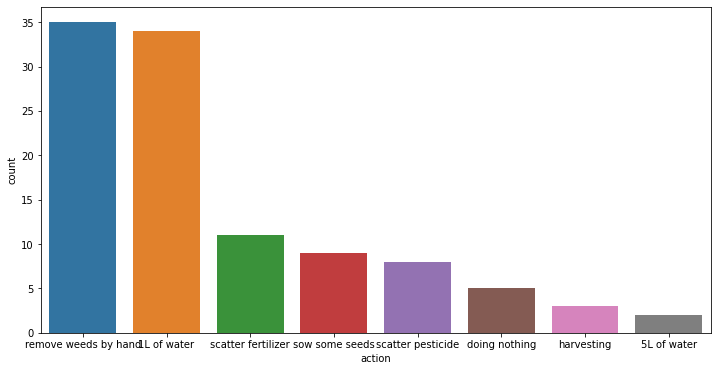

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12,6))
sns.countplot(data = episode, x = "action", order=episode['action'].value_counts().index)

From this, we see that PPO learned that pesticide destroy the soil and should be avoided in small quantity. Herbicide is not useful if we can remove weeds by hand.